## Guides and Documentation for Bot

- Aiogram documentation ---> https://docs.aiogram.dev/en/v3.20.0.post0/

- __file__ documentation ---> https://www.geeksforgeeks.org/python/__file__-a-special-variable-in-python/

## Docker Compose code to set up pgadmin in case below...

- If ./pgadmin directory doesn't exist, Docker will create it. This volume ensures pgAdmin settings/data persist.

- You can uncomment this section in your docker-compose.yml to enable pgAdmin.

- Create named volumes instead of local folders like ./data and ./pgadmin

### Remember about ports: 

- `5432` = the internal port inside the container where PostgreSQL listens (default for Postgres).

- `5425` = the external port on your VPS host machine.

- `127.0.0.1` - use localhost IP address to communicate with itself for testing before Server IP 

- pgadmin: http://localhost:5050

Final result: http://127.0.0.1:5050

## Database Init 

- Example docker compose for postgresql with db init script on [GitHub](https://gist.github.com/onjin/2dd3cc52ef79069de1faa2dfd456c945)


## Make sure `.env` file contains these variables for pgadmin:

```shell
PGADMIN_DEFAULT_EMAIL=your@email.com
PGADMIN_DEFAULT_PASSWORD=yourpassword
PGADMIN_PORT_HOST=5050  # or any available port on your host
```

## Dockerfile 

- Docker ARG, ENV and .env - a Complete Guide --> https://vsupalov.com/docker-arg-env-variable-guide/

- Understanding the Docker USER Instruction ---> https://www.docker.com/blog/understanding-the-docker-user-instruction/

`docker build -t (tag name) .` - command to create a working image.

`docker-compose up -d --build` to creare Dockerfile with compose together:

- bot_stocki (your bot)

- db_bot_telegram (Postgres)

- pgadmin_db_bot (pgAdmin)


## Guide to help create Docker-Compose in Terminal

`docker compose up -d` a command that starts your Docker application and all services in the YAML file.It can perform a number of tasks, including: building docker images, creating networks and volumes,starting containers and linking containers together.

`docker ps` only shows running containers by default (progress status). To see all containers, use the --all (or -a ) flag.

`docker compose down` is used to stop and remove containers, networks, volumes, and images that were created by docker-compose up.

`docker start <container_name_or_id>` to start again a container.

`docker-compose build` to create full image with Dockerfile connected to compose.yml and .env

## Guide for connecting psql with Docker from terminal 

psql tutorial and cheat sheet ---> https://tomcam.github.io/postgres/

**`docker-compose exec (service name) psql -U POSTGRES_USER -d POSTGRES_DB`** 
- service name - name of your service in .yml file.
- USER and DB info from .env file that connects with docker-compose.yml to run database from docker.

`psql -d database -U user -W`  connects to a database under a specific user.

`\l` or `list` shows list of databases

`\dt` shows list of available tables from database we are connected to

`\d <table name>` show the structure of a table (columns, types, modifiers)

`\c <database>` connect to a specific database

For more information ---> [PostgreSQL command line cheatsheet](https://gist.github.com/Kartones/dd3ff5ec5ea238d4c546)

### User and Permissions to check

`\du` list all roles in db (users)

`\dg` check role memberships and permissions

`\z` shows access privileges for all tables

## Folder `bot/` Structure

`db/`  contains files related to db interaction 
Example:

- `__init__.py` marks the folder as python package, collections of modules for organizing code into modules and packages for relative imports to work clean 

- `close.py` closes connection if need it 

- `connect.py` creates connection for bot 

File initializes:
- the Bot and Dispatcher
- anything global like filters, logging

`config.py` handles environment configuration using `.env` variables
- using classe/objects types for env settings and db

`handlers.py` bot logic for user interaction, reacts to user commands and messages 

`keyboards.py` controls the buttons the users going to click 

`main.py` main setup of the bot to be used across whole application at the moment to run 


## Docker Volumes and How to go under Docker User container from docker-compose file

- `docker-compose exec (service name) bash`

Example in docker-compose.yaml ---> services:
 
   tg_bot_stocki:

- or you can use CONTAINER ID command: `docker exec -it (container ID) bash`

- `ls -a`

- `cat .env`

- `exit`

Check docker volumes

- `docker volume ls` - shows every volume

- `docker volume inspect (volume name)` - shows paramaters

- `docker volume remove (volume name)` - deletes it 

`local` is the default volume driver in Docker.

- It means the volume data is stored on the host machine (your VPS or local system) under Docker’s storage path, typically:

/var/lib/docker/volumes/<volume_name>/_data


## Connect Server on PGADMIN 

Make sure its running on http://127.0.0.1:5050 or any other numbers you put 

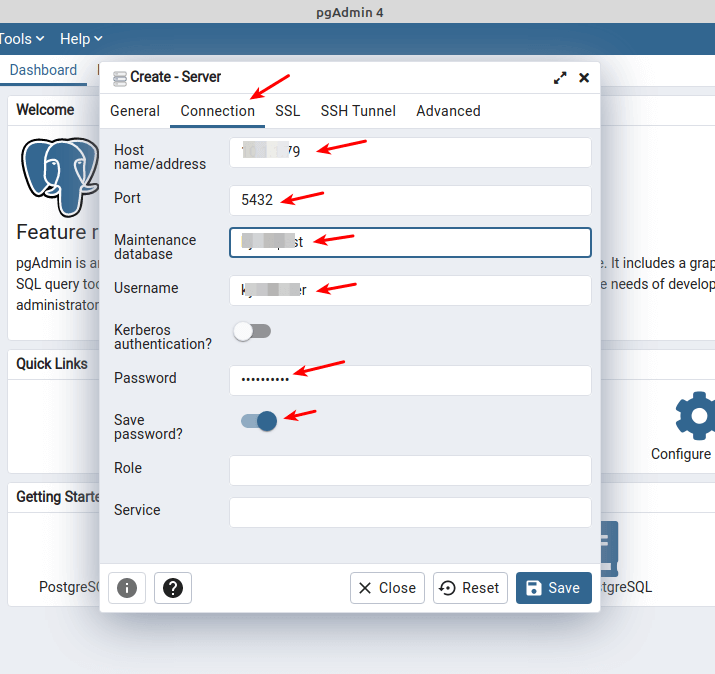

- Host name/address: `postgres_bot_db` from docker-compose.yml

- Port: `5432` from docker-compose.yml

- Maintenance database: `POSTGRES_DB` from `.env` file

- Username: `POSTGRES_USER` from `.env` file

- Password: `POSTGRES_PASSWORD` from `.env` file

## Extra handlers and commands

Possibility to add a /help command in `handlers.py`, but not yet decided

- from handlers import setup_commands
- dp.startup.register(setup_commands)


In [ ]:
# Help command handler 
@dp.message(Command("help"))
async def help(message: Message):
    await message.answer(
        f"Something doesn't work? Text directly to the dev {settings.LEAD_ADMIN_USERNAME}"
    )
# Registering command for bot 
async def setup_commands(bot: Bot):
    await bot.set_my_commands([
        BotCommand(command="help", description="Help information")
    ])

# Используем легкий официальный образ Python
FROM python:3.12-slim AS base

LABEL maintainer="Telegram bot: https://t.me/StockiDeFi_bot"

# Создаем пользователя для запуска бота
ARG UID=1000
ARG GID=1000
ENV UID=${UID}
ENV GID=${GID}


RUN useradd -m -u $UID docker_user

# Устанавливаем рабочую директорию
WORKDIR /home/docker_user/app

# Копируем и устанавливаем зависимости как root
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Копируем весь проект
COPY . .

# Переключаемся на непривилегированного пользователя
USER docker_user

# Настройки Python
ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1

# Запуск бота через модуль
CMD ["python3", "-m", "bot.main"]


LABEL author="Your Name"
LABEL version="1.0"
LABEL description="Stocki DeFi Telegram Bot"

The Dockerfile alone didn't work because of the environment variable issue. Here's what was happening:
With just Dockerfile:

Your .env file was in .dockerignore - so it never got copied into the Docker image
No environment variables - when your config.py tried to read os.environ.get("BOT_TOKEN"), it got None
Bot failed - aiogram couldn't validate a None token

With docker-compose:

Docker-compose reads your .env file with the env_file: - .env directive
Passes environment variables to the container at runtime (not baked into the image)
Your bot gets the variables - os.environ.get("BOT_TOKEN") now returns your actual token

The key difference:
Dockerfile alone: Environment variables must be either:

Copied into the image (security risk)
Passed manually with docker run -e BOT_TOKEN=xxx

Docker-compose: Automatically handles environment variables from your .env file and passes them to containers at runtime.
Why docker-compose is better:

Secure: .env stays out of the image but variables still reach your app
Easy: No need to manually pass dozens of -e flags
Production-ready: Standard approach for multi-container applications
Maintainable: One file manages your entire stack

This is why docker-compose is the preferred approach for applications that need databases, environment variables, and multiple services working together.

The Connection Flow:
`tg_bot_stocki:`

 ` build:`

` context: .    ` # This tells docker-compose to BUILD your Dockerfile

What happens here:

Docker-compose looks for a Dockerfile in the current directory (.)
Runs docker build . automatically
Creates an image from your Dockerfile
Uses that image to create the container

Each Line Explained:
`container_name: bot_stocki`

Names the running container "bot_stocki" instead of auto-generated name

`env_file:`

  - `.env`

Reads your .env file from the host machine
Passes ALL variables to the container at runtime
This is why os.environ.get("BOT_TOKEN") now works

environment:

  - `POSTGRES_HOST=postgres_bot_db`

Overrides the POSTGRES_HOST from `.env` file
Sets it to the database service name for internal Docker networking

depends_on:

  - `postgres_bot_db`

Ensures database starts before the bot
Docker-compose waits for database container to be created

yamlrestart: unless-stopped

If container crashes, automatically restart it
Stops restarting only if you manually stop it

The Complete Process:

Build Phase: Docker-compose finds your Dockerfile and builds it into an image
Environment Phase: Reads your .env file and prepares environment variables
Network Phase: Creates a Docker network for containers to communicate
Runtime Phase: Starts containers with environment variables injected
Connection Phase: Your bot can now connect to postgres_bot_db (the database service name)

Your Dockerfile provides the "what" (the application code and dependencies), while docker-compose provides the "how" (environment, networking, and orchestration).